In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from functools import partial
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
np.set_printoptions(suppress=True)

from models import DeepConditionalModel, InvariantNetwork
from inn_utils import train_loop_active
from simulate_diffusion import simulate_diffusion
from viz import plot_true_est_scatter, plot_true_est_posterior, plot_losses, plot_sbc

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

# Initialization 

In [4]:
def index_parameters(X_batch, theta_batch, indices):
    """
    Indexes only the relevant Levy parameters.
    """
    
    theta_batch = tf.gather(theta_batch, indices, axis=1)
    return X_batch, theta_batch

In [5]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}

parameter_bounds = {
        'v1': [0.0, 6.0],
        'v2': [-6.0, 0.0],
        'sv': [0.0, 0.0],
        'zr': [0.3, 0.7],
        'szr': [0.0, 0.0],
        'a': [0.6, 3.0],
        'ndt': [0.3, 1.0],
        'sndt': [0.0, 0.0],
        'alpha': [1.0, 2.0],
    }


# --- Training hyperparameters --- #
param_names = ['v1', 'v2', 'zr', 'a', 'ndt', 'alpha']
param_indices = [0, 1, 3, 5, 6, 8]
theta_dim = 6
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 32
summary_dim = 128
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 10
n_test = 300
n_samples_posterior = 2000
verbose_each = 100
starter_learning_rate = 0.001
decay_steps = 4000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)

In [6]:
data_generator = partial(simulate_diffusion, pbounds=parameter_bounds)
transform = partial(index_parameters, indices=param_indices)

## Create a test set

In [7]:
X_test, theta_test = simulate_diffusion(n_test, parameter_bounds, n_trials=1000)
X_test, theta_test = transform(X_test, theta_test)

In [21]:
X_test.shape

TensorShape([Dimension(300), Dimension(1000), Dimension(2)])

## Create networks

In [8]:
summary_net = InvariantNetwork(summary_dim, n_equiv=3)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [9]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/levy', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/levy\ckpt-7


## Plot performance of untrained networks

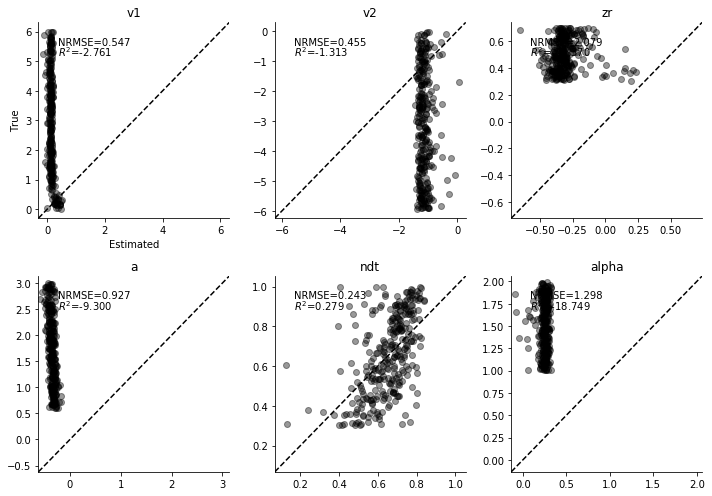

In [32]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 7))

# Train the model

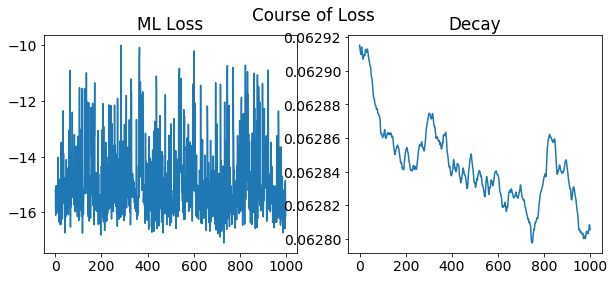

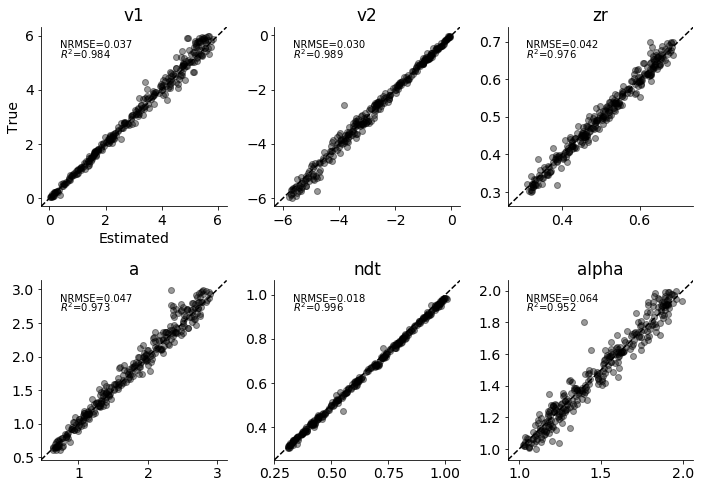

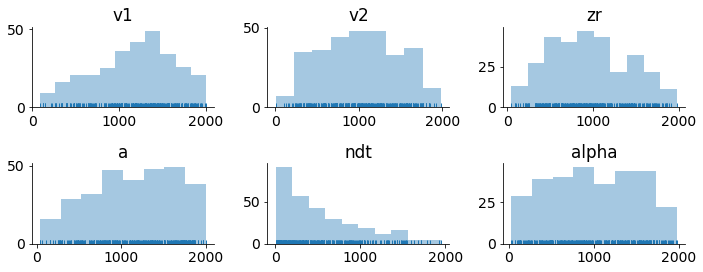

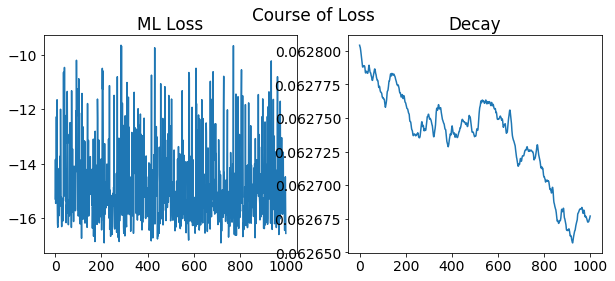

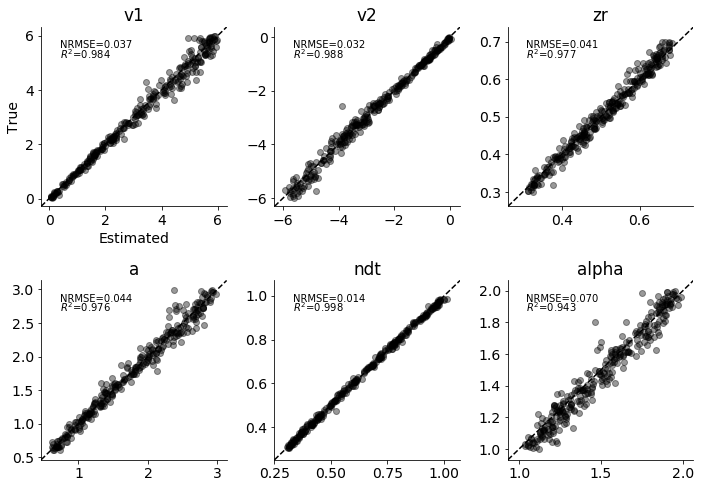

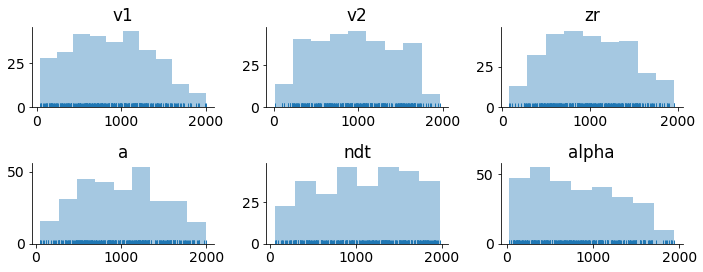

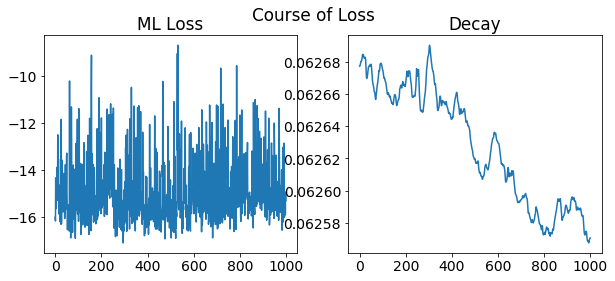

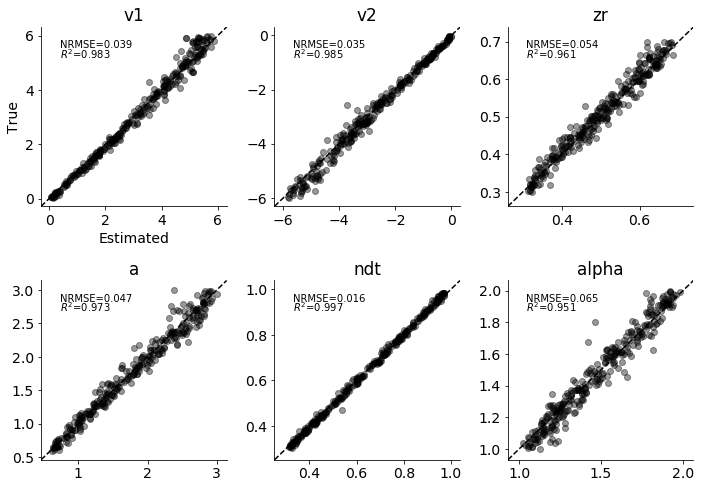

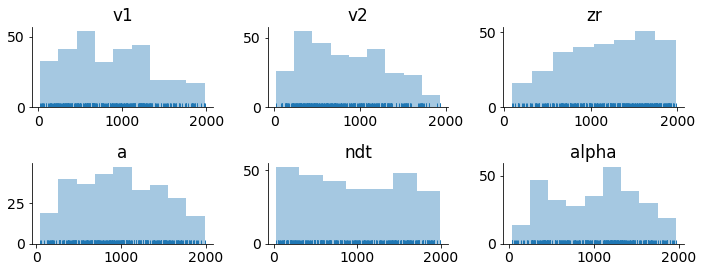

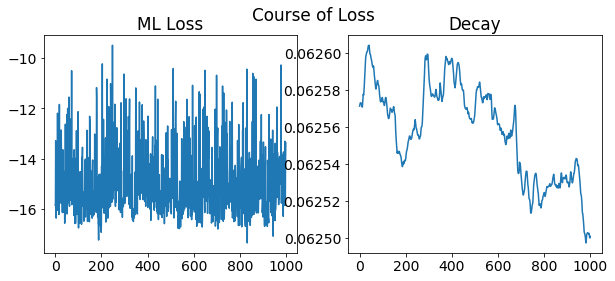

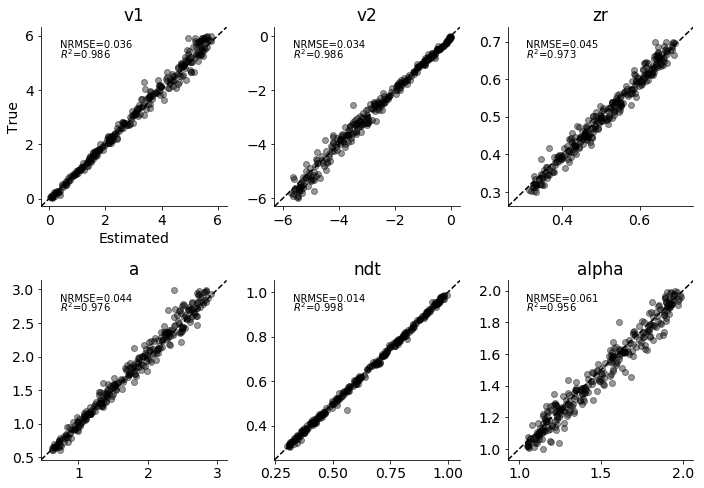

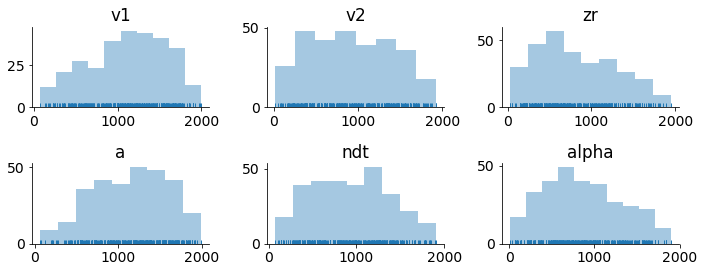

In [ ]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_loop_active(model, optimizer, data_generator, iterations_per_epoch, 
                            batch_size, iterations_per_epoch, p_bar, clip_value=clip_value, 
                            global_step=global_step, transform=transform, ckpt_name='Levy_{}'.format(ep))
        # Plot stuff
        plot_losses(losses, figsize=(10, 4))
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 7))
        plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(10, 4))
        
        # Store checkpoint
        manager.save()

# Evaluate the trained model

## Posterior means (recovery)

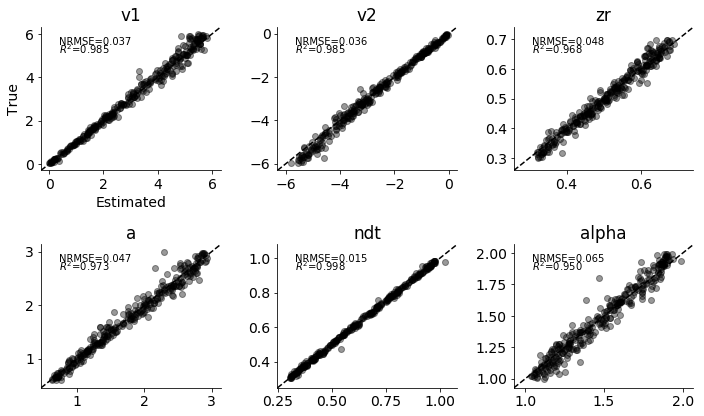

In [34]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 6))

## Full posterior (visual inspection)

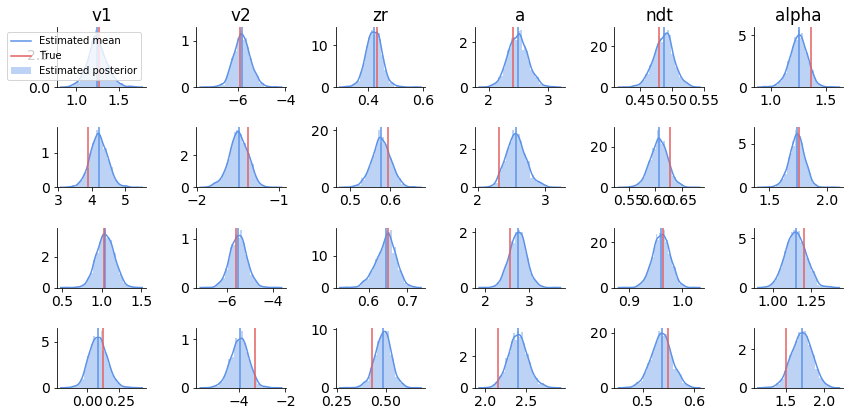

In [24]:
X_test2, theta_test2 = simulate_diffusion(4, parameter_bounds, n_trials=1000)
X_test2, theta_test2 = transform(X_test2, theta_test2)
plot_true_est_posterior(model, n_samples=n_samples_posterior, param_names=param_names, 
                        X_test=X_test2, theta_test=theta_test2, figsize=(12, 6))

## Simulation-based calibration

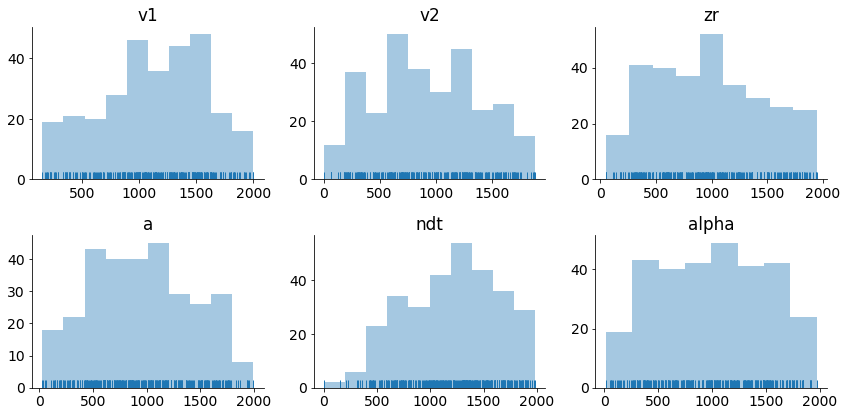

In [35]:
plot_sbc(model, n_samples_posterior, X_test, theta_test, param_names, figsize=(12, 6))